In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
plt.rcParams['lines.linewidth'] = 1
# tweak colors cycle inthe plots
# here i make a list of colors, later I can use it to make custom cycles
default_colors_cycle = plt.rcParams['axes.prop_cycle']()
default_colors_arr = np.array([next(default_colors_cycle)['color'] for x in range(15)])


import umap
import neo

from ceciestunepipe.util.dimension import umapred as dim
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import data as dt


In [3]:
reload(et)
sess_par = {'bird': 'z_w12m7_20',
           'sess': '2020-11-04',
           'probe': 'probe_0',
           'sort': 'sort_4'} #'sort_4' is ks3 manually curated; 'auto_5' is ks3, no manual

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

sess_epochs = et.list_sgl_epochs(sess_par)


### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])
sort_folder = os.path.join(exp_struct['folders']['sort'])

2021-11-10 11:36:12,388 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20', 'raw': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx', 'kwik': '/scratch/earneodo/z_w12m7_20/sglx/kwik/2020-11-04', 'processed': '/mnt/sphere/speech_bci/processed_data/z_w12m7_20/2020-11-04/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/z_w12m7_20/sglx/msort/2020-11-04', 'ksort': '/scratch/earneodo/z_w12m7_20/sglx/ksort/2020-11-04/sort_4', 'sort': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/sort_4'}, 'files': {'par': '/scratch/earneodo/z_w12m7_20/sglx/ksort/2020-11-04/sort_4/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/rig.json', 'kwd': '/scratch/

In [4]:
# load the dict and make the df right away.

bout_dict_file = 'bout_dict_hvc_allunits.pkl'

bout_dict_path = os.path.join(sort_folder, bout_dict_file)

with open(bout_dict_path, 'rb') as fh:
    bout_dict = pickle.load(fh)


keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'start_ms', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df['bout_id'] = bout_df['start_sample_nidq']

mot_len_ms = 550 # looked it up in sglx_pipe-sort_rasters-z_m12w7_20_pouli



### load syllables

In [5]:
syl_dict_path = os.path.join(exp_struct['folders']['derived'], 'syl_dict_ap0.pkl')
with open(syl_dict_path, 'rb') as f:
    syl_dict = pickle.load(f)
    
#syl_dict

In [6]:
syl_df = pd.DataFrame.from_dict(syl_dict)
syl_df.head(2)

,s_f,s_f_nidq,s_f_ap_0,start_ms,len_ms,start_sample_naive,start_sample_nidq,start_sample_wav,start_ms_ap_0,start_sample_ap_0,label
0,25000,24999.716529,30000.008507,12869,25,321725,321722,321726,12869.215103,386077,a
1,25000,24999.716529,30000.008507,13391,23,334775,334772,334776,13391.235984,401738,a


### get which motif each syllable belongs to and where in the motif it starts

In [7]:
bout_df['end_sample_nidq'] = bout_df['start_sample_nidq'] + bout_df['len_ms'] * 0.1 * bout_dict['s_f']

# go through all the bouts and check whether the start of each syllable falls within the start: endd of the bout
# nidq timescale
all_bout_id = bout_df['bout_id'].values

#bout_id = all_bout_id[0]

for bout_id in all_bout_id:
    bout_filter = (bout_df['bout_id'] == bout_id)

    bout_boundaries = bout_df.loc[bout_filter, ['start_sample_nidq', 'end_sample_nidq']].values.flatten()

    syl_df.loc[syl_df['start_sample_nidq'].between(*bout_boundaries), 'bout_id'] = bout_id
    
syl_df['bout_id'] = syl_df['bout_id'].astype(np.int64)

In [8]:
syl_df.tail()

,s_f,s_f_nidq,s_f_ap_0,start_ms,len_ms,start_sample_naive,start_sample_nidq,start_sample_wav,start_ms_ap_0,start_sample_ap_0,label,bout_id
46,25000,24999.716529,30000.008507,7316924,73,182923100,182921026,182923101,7.317007e+06,219510272,e,182905027
47,25000,24999.716529,30000.008507,7317033,73,182925825,182923751,182925826,7.317116e+06,219513542,e,182905027
48,25000,24999.716529,30000.008507,7317705,76,182942625,182940551,182942626,7.317788e+06,219533702,e,182926951
49,25000,24999.716529,30000.008507,7317814,73,182945350,182943276,182945351,7.317897e+06,219536972,e,182926951
50,25000,24999.716529,30000.008507,7317925,79,182948125,182946051,182948126,7.318008e+06,219540302,e,182926951


In [9]:
## the starts in ms of each syllable in the bout
def bout_syl(syl_df, bout_s):
    bout_id = bout_s['bout_id']
    syl_filter = (syl_df['bout_id'] == bout_id)
    #print(syl_filter)
    #syl_pd = syl_df.loc[bout_filter]
    
    syl_labels = syl_df.loc[syl_filter, 'label'].values.flatten()
    syl_start_sample_wav = syl_df.loc[syl_filter, 'start_sample_wav'].values.flatten()
    
    start_ms = syl_df.loc[syl_filter, 'start_ms'].values.flatten()
    
    start_in_bout = start_ms - bout_s['start_ms']
    
    return syl_labels, syl_start_sample_wav, start_ms, start_in_bout
    
bout_df[['syl_labels', 'syl_start_samples_wav', 
         'syl_start_ms','syl_start_ms_in_bout']] = bout_df.apply(lambda s: bout_syl(syl_df, s), 
                                                             axis=1,
                                                            result_type='expand')

#bout_syl(syl_df, bout_df.iloc[0])

In [10]:
bout_df.head(2)

,start_sample_nidq,start_sample_ap_0,start_ms,len_ms,spk_arr,mic_arr,clu_id_arr,bout_id,end_sample_nidq,syl_labels,syl_start_samples_wav,syl_start_ms,syl_start_ms_in_bout
0,321722,386077,12869,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-331, -528, -120, -150, -204, -22, 353, 377, ...","[900, 909, 912, 913, 914, 916, 917, 918, 919, ...",321722,1449222.0,"[a, b, c, d]","[321726, 323151, 327251, 329976]","[12869, 12926, 13090, 13199]","[0, 57, 221, 330]"
1,334772,401738,13391,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-636, -601, -887, -940, -792, -1126, -1216, -...","[900, 909, 912, 913, 914, 916, 917, 918, 919, ...",334772,1462272.0,"[a, b, c, d]","[334776, 336201, 340501, 342951]","[13391, 13448, 13620, 13718]","[0, 57, 229, 327]"


In [11]:
bout_df.head(2)

,start_sample_nidq,start_sample_ap_0,start_ms,len_ms,spk_arr,mic_arr,clu_id_arr,bout_id,end_sample_nidq,syl_labels,syl_start_samples_wav,syl_start_ms,syl_start_ms_in_bout
0,321722,386077,12869,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-331, -528, -120, -150, -204, -22, 353, 377, ...","[900, 909, 912, 913, 914, 916, 917, 918, 919, ...",321722,1449222.0,"[a, b, c, d]","[321726, 323151, 327251, 329976]","[12869, 12926, 13090, 13199]","[0, 57, 221, 330]"
1,334772,401738,13391,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-636, -601, -887, -940, -792, -1126, -1216, -...","[900, 909, 912, 913, 914, 916, 917, 918, 919, ...",334772,1462272.0,"[a, b, c, d]","[334776, 336201, 340501, 342951]","[13391, 13448, 13620, 13718]","[0, 57, 229, 327]"


In [12]:
# load hvc meta dict
meta_dict_path = os.path.join(sort_folder, 'hvc_meta_dict.pkl')
logger.info('saving the hvc meta dict to {}'.format(meta_dict_path))

with open(meta_dict_path, 'rb') as f:
    hvc_meta_dict = pickle.load(f)

hvc_meta_dict.keys()

2021-11-10 11:36:14,786 root         INFO     saving the hvc meta dict to /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/hvc_meta_dict.pkl


dict_keys(['int', 'blur', 'sharp', 'pn'])

In [13]:
clu_pickle_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_pickle_path)

clu_df.head(2)

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,main_chan,MSLabel,has_template,template,max_chans,main_7,main_wav_7,nucleus
3,3,2082.9,100.0,good,90.564789,0,0.0,1.104526,good,8441,0,0,good,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 1, 3, 4, 5, 7, 13, 9, 15, 10, 6, 8, 12,...","[0, 1, 2, 3, 4, 5, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
6,6,2350.7,100.0,good,154.954834,4,40.0,3.162705,good,24170,0,0,good,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 3, 1, 6, 4, 7, 5, 8, 9, 10, 13, 12, 14,...","[0, 1, 2, 3, 4, 6, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


### filter units

In [14]:
def filter_units(bout_df, clu_id_list):
    # assume all spk_arr in bout_df have the same clu_id_arr
    clu_id_arr = bout_df['clu_id_arr'][0] 
    clu_mask = [x in clu_id_list for x in clu_id_arr]
    
    bout_df['spk_arr'] = bout_df['spk_arr'].apply(lambda x: x[clu_mask])
    bout_df['clu_id_arr'] = bout_df['clu_id_arr'].apply(lambda x: x[clu_mask])
    return clu_mask



#### filter good only

In [15]:
# good_clu_id = clu_df.loc[clu_df['MSLabel'].isin(['good']), 'cluster_id'].values
# good_clu_id

# good_clu_mask = filter_units(bout_df, good_clu_id)

#### filter by manual metadata

In [16]:
meta_keys_keep = ['sharp', 'pn']
meta_keys_keep = ['pn']
meta_keys_keep = ['sharp', 'blur']
manual_clu_id = np.concatenate([hvc_meta_dict[k] for k in meta_keys_keep])
good_clu_mask = filter_units(bout_df, manual_clu_id)

In [17]:
clu_id_arr = bout_df['clu_id_arr'][0]
clu_id_arr.shape

(38,)

### get spectrograms and rate-grams

In [18]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'spk_arr', 'mic_arr', 'clu_id_arr', 't_pre_s', 't_post_s'])

#### get mot starts:ends for scaling


In [19]:
bout_df['len_ms']
max_bout_len = np.max(bout_df['len_ms'])

bout_df['t_scale'] = bout_df['len_ms']/max_bout_len 
max_bout_len

bout_df['len'] = bout_df['len_ms'] * bout_dict['s_f']
bout_df['len_scaled'] = bout_df['len'] / bout_df['t_scale']

In [20]:
bout_df['t_scale']

0    0.926078
1    0.926078
2    0.932238
3    0.938398
4    0.944559
5    0.991786
6    0.969199
7    0.975359
8    0.987680
9    1.000000
Name: t_scale, dtype: float64

In [21]:
bout_df.head()

,start_sample_nidq,start_sample_ap_0,start_ms,len_ms,spk_arr,mic_arr,clu_id_arr,bout_id,end_sample_nidq,syl_labels,syl_start_samples_wav,syl_start_ms,syl_start_ms_in_bout,t_scale,len,len_scaled
0,321722,386077,12869,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-331, -528, -120, -150, -204, -22, 353, 377, ...","[976, 1019, 1031, 1033, 1038, 1044, 1045, 1046...",321722,1449222.0,"[a, b, c, d]","[321726, 323151, 327251, 329976]","[12869, 12926, 13090, 13199]","[0, 57, 221, 330]",0.926078,11275000,12175000.0
1,334772,401738,13391,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-636, -601, -887, -940, -792, -1126, -1216, -...","[976, 1019, 1031, 1033, 1038, 1044, 1045, 1046...",334772,1462272.0,"[a, b, c, d]","[334776, 336201, 340501, 342951]","[13391, 13448, 13620, 13718]","[0, 57, 229, 327]",0.926078,11275000,12175000.0
2,347747,417307,13910,454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[366, 258, 9, 270, 302, 400, 708, 791, 684, 57...","[976, 1019, 1031, 1033, 1038, 1044, 1045, 1046...",347747,1482747.0,"[a, b, c, d]","[347751, 349226, 353551, 356101]","[13910, 13969, 14142, 14244]","[0, 59, 232, 334]",0.932238,11350000,12175000.0
3,368671,442417,14747,457,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-515, -554, -651, -317, -420, -333, -239, -28...","[976, 1019, 1031, 1033, 1038, 1044, 1045, 1046...",368671,1511171.0,"[a, b, c, d]","[368676, 370201, 374476, 377076]","[14747, 14808, 14979, 15083]","[0, 61, 232, 336]",0.938398,11425000,12175000.0
4,389821,467798,15593,460,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2433, 4521, 4177, 1790, -601, -1393, -951, -8...","[976, 1019, 1031, 1033, 1038, 1044, 1045, 1046...",389821,1539821.0,"[a, b, c, d]","[389826, 391376, 395651, 398176]","[15593, 15655, 15826, 15927]","[0, 62, 233, 334]",0.944559,11500000,12175000.0


In [22]:
# bout_df['mic_arr_res'] = bout_df.apply()

In [23]:
#bout_dict

In [24]:
s_f_wav = bout_dict['s_f']
bout_df['sxx_all'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), s_f_wav, 
                                                                         f_min=100, f_max=9000)
                                             )

bout_df['sxx'] = bout_df['sxx_all'].apply(lambda x: x[2])

In [25]:
s_f_ap_0 = bout_dict['s_f_ap_0']

bin_size_ms = 1
bin_size_sample = int(bin_size_ms * 0.001 *  s_f_ap_0)

bout_df['fr_arr'] =  bout_df['spk_arr'].apply(lambda x: pu.coarse(x, bin_size_sample))

#### show spectrograms

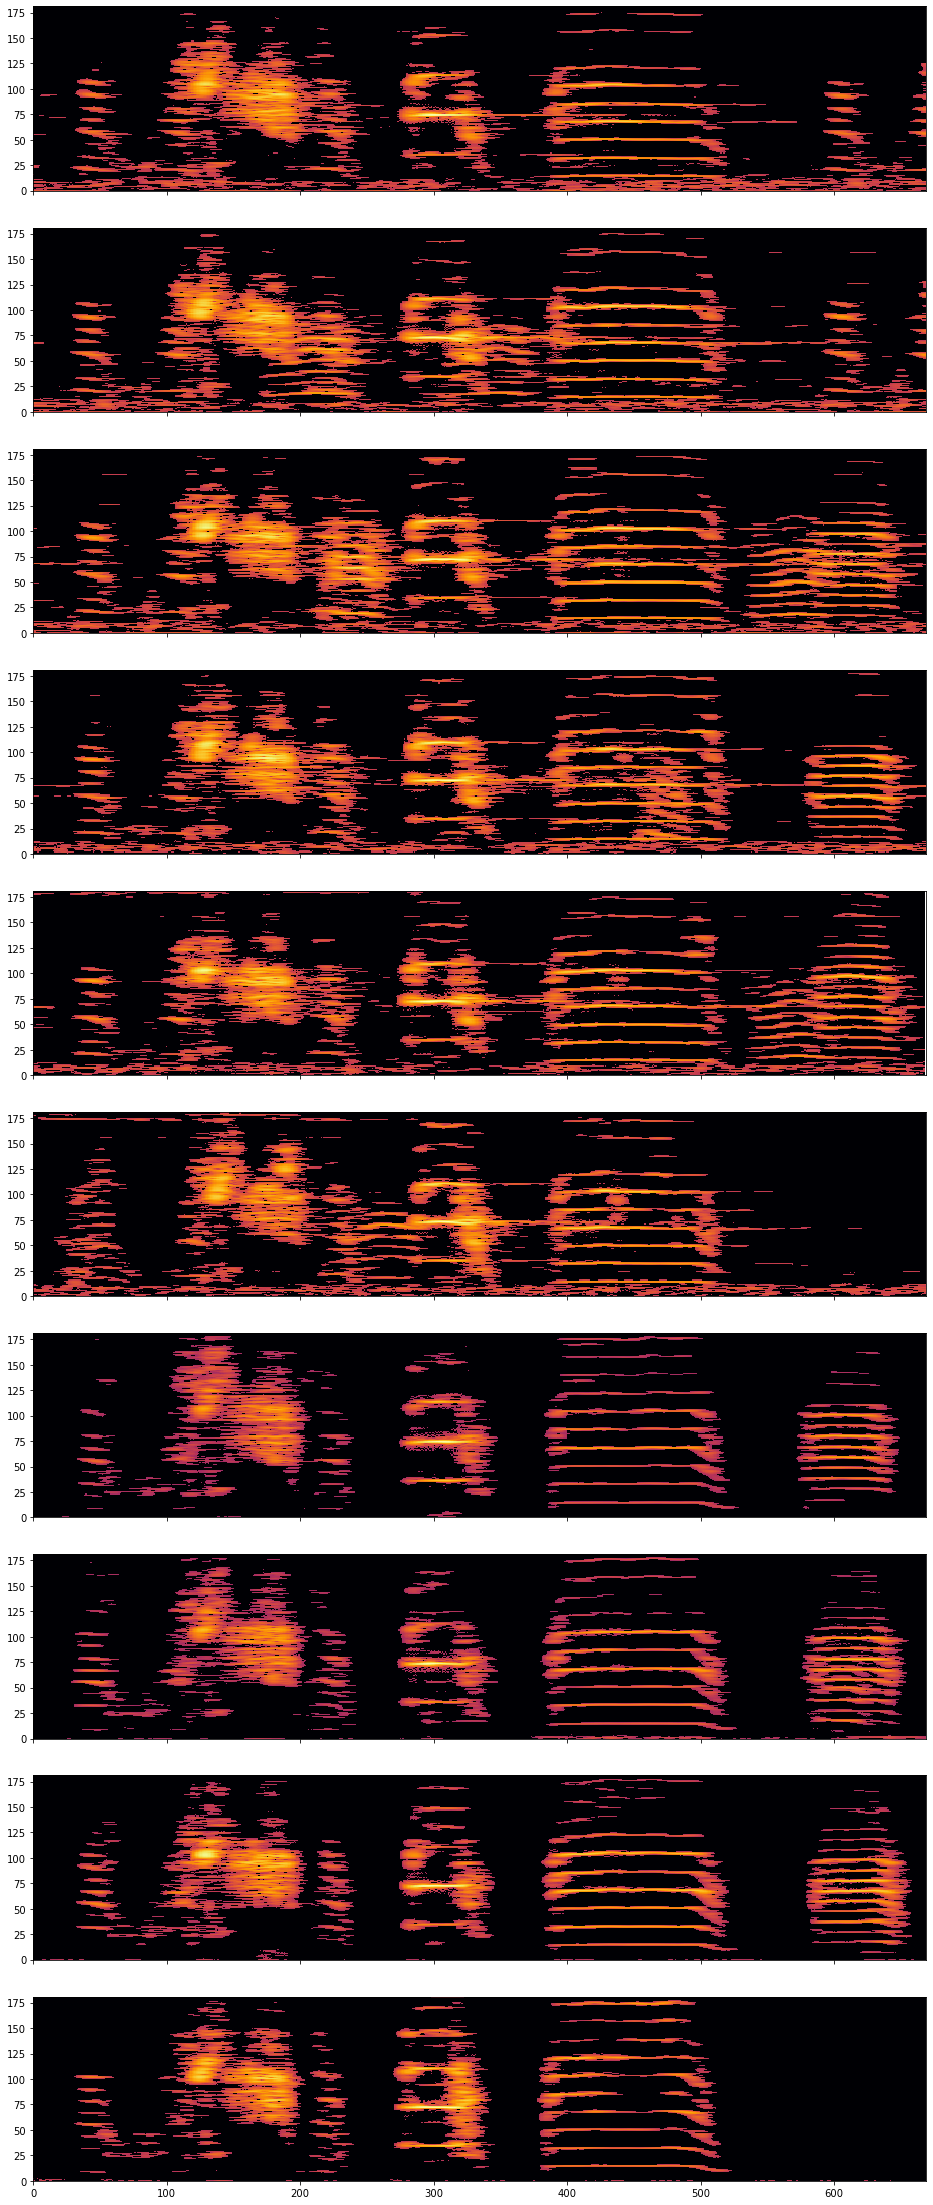

In [26]:
#show_bout = range(n_show)

show_bout = range(10)
n_show = len(show_bout) 
fig, ax = plt.subplots(nrows=n_show, figsize=(16, 4*n_show), sharex=True)

t_pre = bout_dict['t_pre_s']
mot_len_ms = 670

start_in_bout = int(np.abs(t_pre) * 1000) - 40 # in miliseconds, 20 is the spectrogram bin size
end_in_bout = int(start_in_bout + mot_len_ms) # in miliseconds

bout_df['end_in_bout'] = bout_df['t_scale'] * mot_len_ms + start_in_bout


#bout_df['sxx_chop'] = bout_df['sxx'].apply(lambda x: x[:, start_in_bout: end_in_bout])
bout_df['sxx_chop'] = bout_df.apply(lambda x: x['sxx'][:, start_in_bout: int(x['end_in_bout'])],
                                   axis=1)
#bout_df['sxx_chop'] = bout_df.apply(lambda x: x['sxx_chop'][:, :x['len_ms']], axis=1)

def plot_bout(bout_series, ax, cmap='inferno'):
    sxx = bout_series['sxx_chop']
    #print(sxx.shape)
    t = np.arange(sxx.shape[1]) / bout_series['t_scale']
    f = np.arange(sxx.shape[0])
    ax.pcolormesh(t, f, np.log(sxx), cmap=cmap)
    return ax

for i_ax, i_bout in enumerate(show_bout):
#     ax[i_ax].imshow(np.log(bout_df.iloc[i_bout]['sxx_chop'][::-1]), 
#                     aspect='auto', interpolation='nearest',
#                     cmap='inferno')
    #ax[i_ax].pclormap()
#     sxx = bout_df.iloc[i_bout]['sxx_chop'][::]
#     t = np.arange(sxx.shape[1]) / bout_df.iloc[i_bout]['t_scale']
#     f = np.arange(sxx.shape[0])
#     ax[i_ax].pcolormesh(t, f, np.log(sxx), cmap='inferno')
#     ax[i_ax].set_title('i_bout {}'.format(i_bout))
    plot_bout(bout_df.iloc[i_bout], ax[i_ax])



In [27]:
## three different motifs (short: ends in silence -with the bout-, long: has an extra syllable, standard: ends with first syllable of next motif)
bout_dict['mot_kind'] = np.array([0, 0, 1, 1, 1, 2, 1, 1, 1, 2])
bout_df['mot_kind'] = bout_dict['mot_kind'] 

In [28]:
bout_df['t_scale'] * mot_len_ms

0    620.472279
1    620.472279
2    624.599589
3    628.726899
4    632.854209
5    664.496920
6    649.363450
7    653.490760
8    661.745380
9    670.000000
Name: t_scale, dtype: float64

In [29]:
bout_df['len_ms']

0    451
1    451
2    454
3    457
4    460
5    483
6    472
7    475
8    481
9    487
Name: len_ms, dtype: int64

In [30]:
bout_df['end_in_bout']

0    5580.472279
1    5580.472279
2    5584.599589
3    5588.726899
4    5592.854209
5    5624.496920
6    5609.363450
7    5613.490760
8    5621.745380
9    5630.000000
Name: end_in_bout, dtype: float64

### gpfa for a bout

In [31]:
def spike_trains_from_bout(bout_s: pd.Series, s_f=30000):
    # get the bout spike array
    spk_arr = bout_s['spk_arr']
    
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

i_bout = 5
bout_spk_trains = spike_trains_from_bout(bout_df.iloc[i_bout])

# get thte spike trains for all bouts
all_bout_idx = list(bout_df.index)
all_spk_trains = [spike_trains_from_bout(bout_df.iloc[i_bout]) for i_bout in all_bout_idx]

### get also the spectrograms
all_spectrograms_list = [bout_df.iloc[i_bout]['sxx'] for i_bout in all_bout_idx]

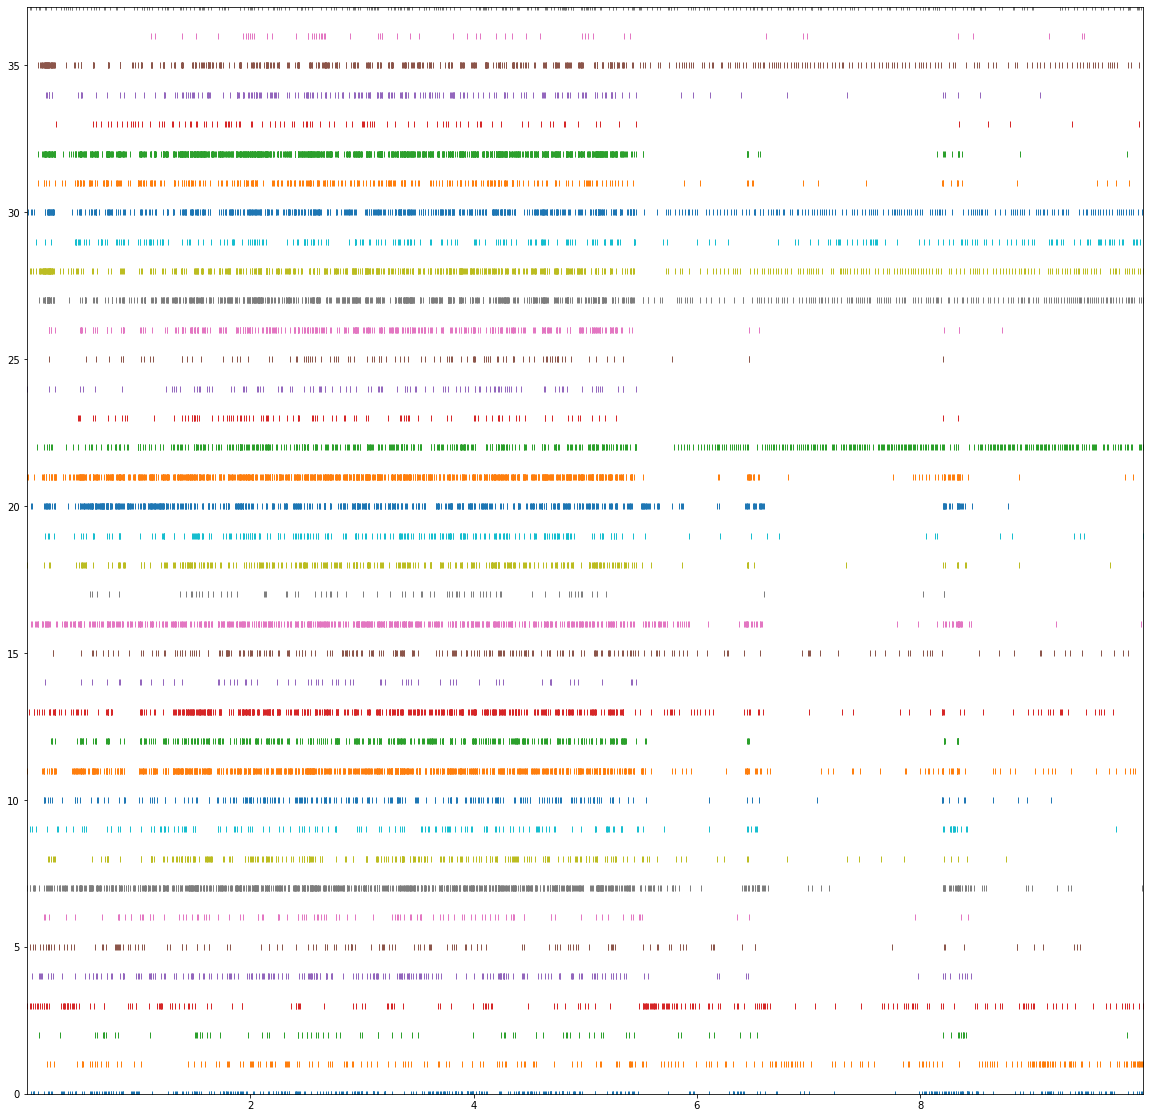

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))

for i, spiketrain in enumerate(bout_spk_trains):
    ax.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

In [33]:
import quantities as pq
from elephant.gpfa import GPFA

# specify fitting parameters
bin_ms = 15
bin_size = bin_ms * pq.ms

latent_dimensionality = 10

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [34]:
gpfa_2dim.fit(all_spk_trains)
print(gpfa_2dim.params_estimated.keys())

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 10 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 9 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:11

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


#### get the trajectories for all the trials now

In [35]:
# get the trajectories for all the trials now
trial_trajectories = gpfa_2dim.transform(all_spk_trains)
# arrange them all into a single array [trial, latent_dim, bin]
trial_trajectories_arr = np.stack(trial_trajectories, axis=0)
trial_trajectories_arr.shape

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 10 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 9 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:11

(10, 10, 666)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f97106eef10>)

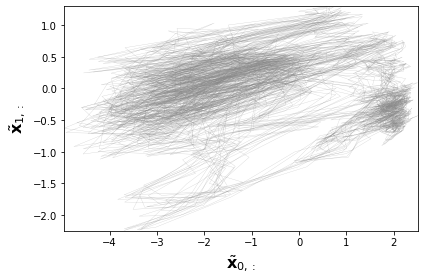

In [36]:
import viziphant as vp
vp.gpfa.plot_trajectories(trial_trajectories, gpfa_2dim, 
                                n_trials_to_plot=5, 
                                plot_group_averages=True)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9710612040>)

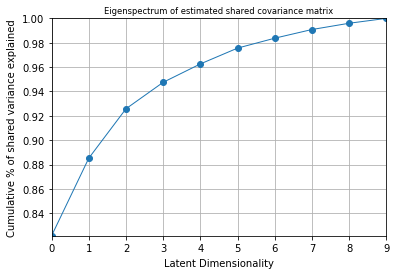

In [37]:
vp.gpfa.plot_cumulative_shared_covariance(gpfa_2dim.params_estimated['C'])

In [38]:
trial_trajectories[0].shape

(10, 666)

#### chop all trayectories to the motif

In [39]:
def bout_syl(syl_df, bout_s):
    bout_id = bout_s['bout_id']
    syl_filter = (syl_df['bout_id'] == bout_id)
    #print(syl_filter)
    #syl_pd = syl_df.loc[bout_filter]
    
    syl_labels = syl_df.loc[syl_filter, 'label'].values.flatten()
    syl_start_sample_wav = syl_df.loc[syl_filter, 'start_sample_wav'].values.flatten()
    
    start_ms = syl_df.loc[syl_filter, 'start_ms'].values.flatten()
    
    start_in_bout = start_ms - bout_s['start_ms']
    
    return syl_labels, syl_start_sample_wav, start_ms, start_in_bout
    
bout_df[['syl_labels', 'syl_start_samples_wav', 
         'syl_start_ms','syl_start_ms_in_bout']] = bout_df.apply(lambda s: bout_syl(syl_df, s), 
                                                             axis=1,
                                                            result_type='expand')

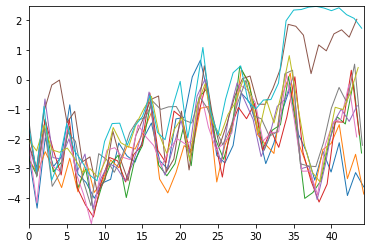

In [45]:
### time warp each to the longest and interpolate
# get the corresponding length and resample interpolate it
mot_start_bin = int(start_in_bout / bin_ms)

traj_list = []
t_list = []

for i_bout, one_trial_traj in enumerate(trial_trajectories):
    bout_s = bout_df.iloc[i_bout]
    one_end_bin = int(bout_s['end_in_bout'] / bin_ms)
    # get the time scale
    # get as many samples of the trajetory starting in start_in_bout
    one_traj = one_trial_traj[:, mot_start_bin: one_end_bin]
    one_t = np.arange(one_traj.shape[1])/bout_s['t_scale']
    plt.plot(one_t, one_traj[0])
    traj_list.append(one_traj)
    t_list.append(one_t)
    
    # get the samples at the syllable onsets already
    bout_id = bout_s['bout_id']
    syl_filter = (syl_df['bout_id'] == bout_id)
    
    def chop_syl_traj(s):
        start = int(s['syl_start_ms_in_bout']/bin_ms)
        end = start + int(s['syl_start_ms_in_bout']/bin_ms)
        
        return one_trial_traj[:, start:end]
    
    #syl_df['gpfa'] = syl_df.loc[syl_filter].apply(lambda s: chop_syl_traj(s))
    
# get these in the bout_df
bout_df['gpfa_traj'] = traj_list
bout_df['gpfa_t_scaled'] = t_list

In [46]:
mot_start_bin

330

In [47]:
max_traj_len = np.max([x.shape[1] for x in traj_list])
max_traj_len

all_traj_arr = np.stack([signal.resample(x, max_traj_len, axis=1) for x in traj_list], axis=0)

In [48]:
all_traj_arr.shape

(10, 10, 45)

In [49]:
# now it's easy to get the trajectories for the motifs
#mot_trajectories = trial_trajectories[:, :, mot_start_bin: mot_end_bin]
mot_trajectories = all_traj_arr
mot_trajectories.shape

# and the average by 'kind' of motif
avg_traj = [np.median(mot_trajectories[bout_dict['mot_kind']==x], axis=0) for x in np.unique(bout_dict['mot_kind'])]
avg_traj_arr = np.stack(avg_traj, axis=0)

In [50]:
# tweak colors cycle inthe plots
# here i make a list of colors, later I can use it to make custom cycles

# make a cycle of 10 colors, ordered as the number of different kinds of motifs,
# so that each 'kind' will plot at a unique different color

colors_pick = default_colors_arr[[0, 2, 3]]
color_cycle_list = [colors_pick[i] for i in bout_dict['mot_kind']]

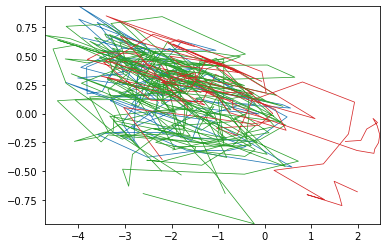

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=color_cycle_list)

for single_trial_trajectory in mot_trajectories[:]:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[2], '-', lw=0.75)

#ax.plot(avg_trajectories[0], avg_trajectories[1], 'c-.', lw=2);

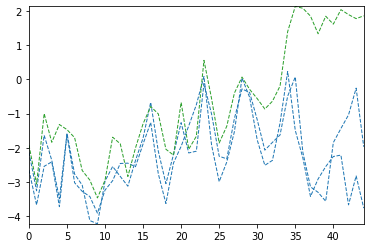

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=color_cycle_list)
ax.plot(avg_traj_arr[:, 0].T, '--')

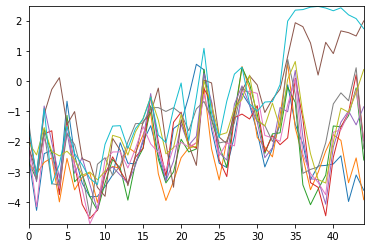

In [53]:
for i, mt in enumerate(mot_trajectories) :
    lc = 0
    plt.plot(mt[0]);

### get trajectories at certain points

In [54]:
# get a sample of the rescaled traces at the onsets (+/- delay) of syllables, as seen by the motif
# that was the longest (t_scale=1)
syl_sample_t = bout_df.loc[bout_df['t_scale']==1, 'syl_start_ms_in_bout'].values[0] + 15
syl_sample_bin = ((syl_sample_t/bin_ms)).flatten().astype(int)

syl_sample_bin

array([ 1,  5, 17, 24])

In [55]:
mot_trajectories.shape

(10, 10, 45)

In [56]:
traj_samples = mot_trajectories[:, :, syl_sample_bin]
avg_samples = avg_traj_arr[:, :, syl_sample_bin]
all_avg_samples = np.mean(avg_samples, axis=0)

In [57]:
all_avg_samples.shape

(10, 4)

In [58]:
syl_df.head()

,s_f,s_f_nidq,s_f_ap_0,start_ms,len_ms,start_sample_naive,start_sample_nidq,start_sample_wav,start_ms_ap_0,start_sample_ap_0,label,bout_id
0,25000,24999.716529,30000.008507,12869,25,321725,321722,321726,12869.215103,386077,a,321722
1,25000,24999.716529,30000.008507,13391,23,334775,334772,334776,13391.235984,401738,a,334772
2,25000,24999.716529,30000.008507,13910,28,347750,347747,347751,13910.217541,417307,a,347747
3,25000,24999.716529,30000.008507,14747,26,368675,368671,368676,14747.211866,442417,a,368671
4,25000,24999.716529,30000.008507,15593,28,389825,389821,389826,15593.261890,467798,a,389821


In [59]:
traj_samples.shape

(10, 10, 4)

In [60]:
all_avg_samples.shape

(10, 4)

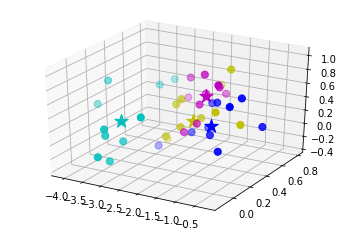

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_prop_cycle(color=color_cycle_list)
syl_color_list = ['c', 'm', 'y', 'b']

for i_syl, syl_color in enumerate(syl_color_list):
    f_2 = 2
    f_3 = 1
    
    ax.scatter(traj_samples[:, 0, i_syl], 
            traj_samples[:, f_2, i_syl], 
            traj_samples[:, f_3, i_syl],
            '.', s=50, color=syl_color)
    #ax.plot(avg_samples[:, 0, i_syl], avg_samples[:, 2, i_syl], '*', lw=0.75, color=syl_color)
    
    ax.scatter([all_avg_samples[0, i_syl]], 
            [all_avg_samples[f_2, i_syl]],
            [all_avg_samples[f_3, i_syl]], marker='*', s=200, color=syl_color)

In [62]:
all_avg_samples[0, i_syl]

-1.1659953404101049

In [63]:
syl_color_list

['c', 'm', 'y', 'b']

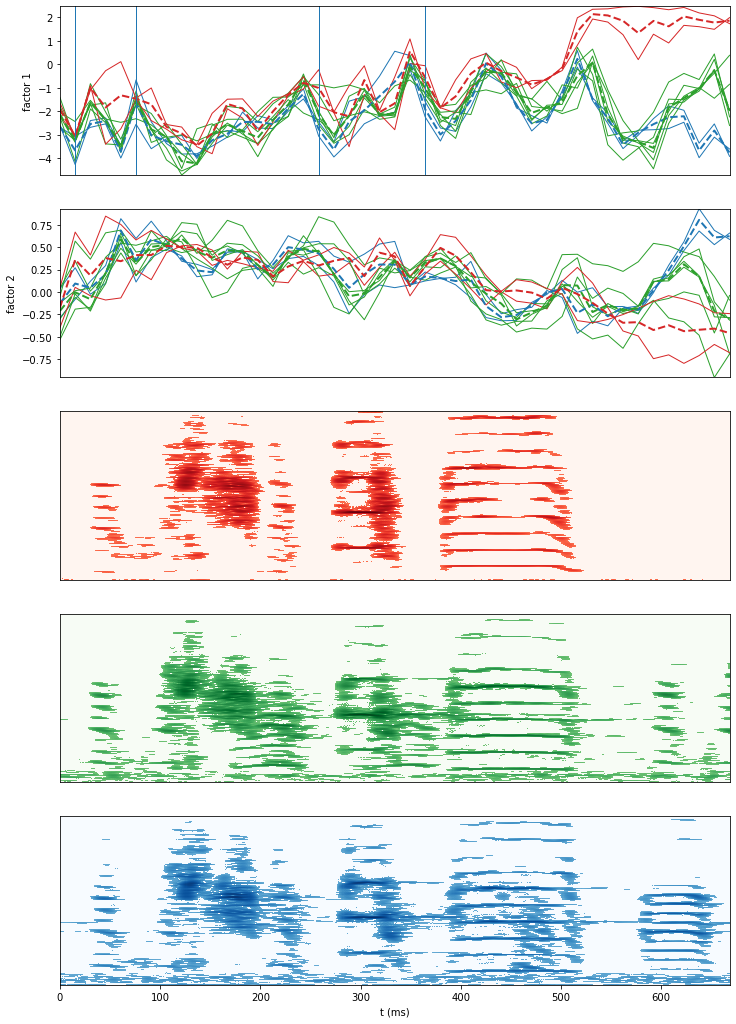

In [64]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
#color_cycle = 
colors_pick = default_colors_arr[[0, 2, 3]]
color_cycle = [colors_pick[i] for i in bout_dict['mot_kind']] + list(colors_pick)

list(map(lambda x: x.set_prop_cycle(color=color_cycle), ax))


ax[0].plot(mot_trajectories[:, 0].T);
ax[0].plot(avg_traj_arr[:, 0].T, '--', lw=2)
ax[0].set_ylabel('factor 1')

[ax[0].axvline(x) for x in syl_sample_bin]


ax[1].plot(mot_trajectories[:, 2].T);
ax[1].plot(avg_traj_arr[:, 2].T, '--', lw=2)
ax[1].set_ylabel('factor 2')

# for i in range(3, 6):
#     ax[i].plot(mot_trajectories[:, i].T);
#     ax[i].plot(avg_traj_arr[:, i].T, '--', lw=2)

plot_bout(bout_df.iloc[9], ax[2], cmap='Reds')

plot_bout(bout_df.iloc[1], ax[3], cmap='Greens')

plot_bout(bout_df.iloc[3], ax[4], cmap='Blues')
ax[4].set_xlabel('t (ms)')


for one_ax in ax[:-1]:
    one_ax.set_xlabel('')
    one_ax.set_xticks([])

for one_ax in ax[2:]:
    one_ax.set_yticks([])


In [ ]:
raise KeyboardInterrupt

#### get trajectories at certain points

In [65]:
syl_df.head(1)

,s_f,s_f_nidq,s_f_ap_0,start_ms,len_ms,start_sample_naive,start_sample_nidq,start_sample_wav,start_ms_ap_0,start_sample_ap_0,label,bout_id
0,25000,24999.716529,30000.008507,12869,25,321725,321722,321726,12869.215103,386077,a,321722


In [66]:
bout_df.keys()

Index(['start_sample_nidq', 'start_sample_ap_0', 'start_ms', 'len_ms',
       'spk_arr', 'mic_arr', 'clu_id_arr', 'bout_id', 'end_sample_nidq',
       'syl_labels', 'syl_start_samples_wav', 'syl_start_ms',
       'syl_start_ms_in_bout', 't_scale', 'len', 'len_scaled', 'sxx_all',
       'sxx', 'fr_arr', 'end_in_bout', 'sxx_chop', 'mot_kind', 'gpfa_traj',
       'gpfa_t_scaled'],
      dtype='object')

In [67]:
# get a sample of the rescaled traces at the onsets (+/- delay) of syllables, as seen by the motif
# that was the longest (t_scale=1)
syl_sample_t = bout_df.loc[bout_df['t_scale']==1, 'syl_start_ms_in_bout'].values[0] + 15
syl_sample_bin = ((syl_sample_t/bin_size_ms)).flatten().astype(int)

syl_sample_bin

array([ 15,  78, 260, 365])

[  0.          61.54988914 238.64079823 356.34146341]


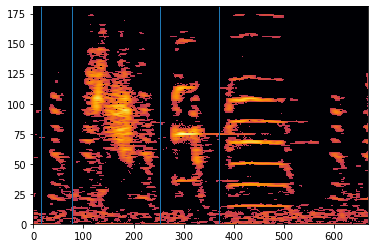

In [68]:

def plot_bout(bout_series, ax, cmap='inferno', plot_syl=False):
    sxx = bout_series['sxx_chop']
    #print(sxx.shape)
    t_scale = bout_series['t_scale']
    
    t0 = np.arange(sxx.shape[1])
    t = np.arange(sxx.shape[1]) / t_scale
    f = np.arange(sxx.shape[0])
    
    ax.pcolormesh(t, f, np.log(sxx), cmap=cmap)
    
    if plot_syl: 
        t_syl = bout_series['syl_start_ms_in_bout'] / t_scale
        print(t_syl)
        delay = 15 # comes from the 40 of the start_in_bout, minus a delay of 25
                    # 40 should be well aligned to syllable onsets
        for t_s in t_syl:
            ax.axvline(t_s + delay)
    return ax

fig, ax = plt.subplots(nrows=1, ncols=1)

plot_bout(bout_df.iloc[0], ax, plot_syl=True)

### save trajectories

In [69]:
traj_file_path = os.path.join(exp_struct['folders']['sort'], 'hvc_gpfa.pickle')
traj_dict = {'mot_trajectories': mot_trajectories,
            'avg_traj_arr': avg_traj_arr,
            'trial_trajectories_list': trial_trajectories}

with open(traj_file_path, 'wb') as f:
    pickle.dump(traj_dict, f)
    
traj_file_path

'/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/hvc_gpfa.pickle'

## Connect to RA trajectories

##### load ra trajectories

In [70]:
traj_file_path = os.path.join(exp_struct['folders']['sort'], 'ra_gpfa.pickle')

with open(traj_file_path, 'rb') as f:
    ra_dict = pickle.load(f)

ra_dict.keys()

dict_keys(['mot_trajectories', 'avg_traj_arr', 'trial_trajectories_list'])

#### plot them together

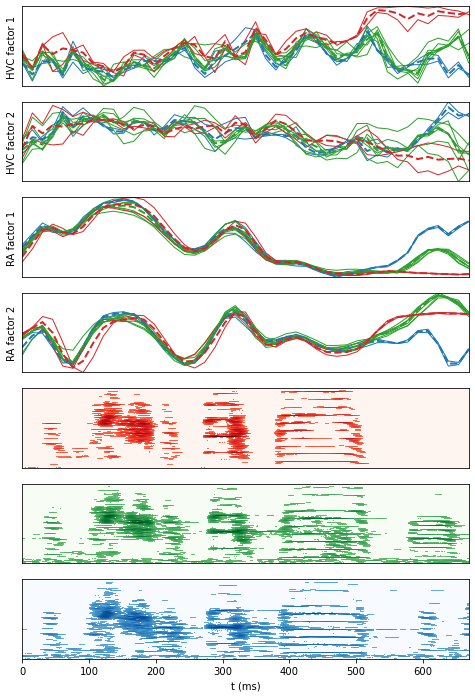

In [71]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(8, 12))
#color_cycle = 
colors_pick = default_colors_arr[[0, 2, 3]]
color_cycle = [colors_pick[i] for i in bout_dict['mot_kind']] + list(colors_pick)

list(map(lambda x: x.set_prop_cycle(color=color_cycle), ax))


ax[0].plot(mot_trajectories[:, 0].T);
ax[0].plot(avg_traj_arr[:, 0].T, '--', lw=2)
ax[0].set_ylabel('HVC factor 1')

#[ax[0].axvline(x) for x in syl_sample_bin]


ax[1].plot(mot_trajectories[:, 2].T);
ax[1].plot(avg_traj_arr[:, 2].T, '--', lw=2)
ax[1].set_ylabel('HVC factor 2')


ax[2].plot(ra_dict['mot_trajectories'][:, 0].T);
ax[2].plot(ra_dict['avg_traj_arr'][:, 0].T, '--', lw=2)
ax[2].set_ylabel('RA factor 1')

#[ax[0].axvline(x) for x in syl_sample_bin]


ax[3].plot(ra_dict['mot_trajectories'][:, 1].T);
ax[3].plot(ra_dict['avg_traj_arr'][:, 1].T, '--', lw=2)
ax[3].set_ylabel('RA factor 2')

# for i in range(3, 6):
#     ax[i].plot(mot_trajectories[:, i].T);
#     ax[i].plot(avg_traj_arr[:, i].T, '--', lw=2)

plot_bout(bout_df.iloc[9], ax[4], cmap='Reds')

plot_bout(bout_df.iloc[3], ax[5], cmap='Greens')

plot_bout(bout_df.iloc[1], ax[6], cmap='Blues')
ax[6].set_xlabel('t (ms)')


for one_ax in ax[:-1]:
    one_ax.set_xlabel('')
    one_ax.set_xticks([])

for one_ax in ax[:]:
    one_ax.set_yticks([])
    
    


In [72]:
#### save this plot for the r21 grant

for ext in ['pdf', 'png']:
    plot_path = os.path.join(exp_struct['folders']['sort'], 'traj_mot_ra-hvc.' + ext)
    logger.info('saving fig as ' + plot_path)
    fig.savefig(plot_path)



2021-11-10 11:45:09,964 root         INFO     saving fig as /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/traj_mot_ra-hvc.pdf
2021-11-10 11:45:53,495 root         INFO     saving fig as /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/traj_mot_ra-hvc.png


In [ ]:
ra_dict.keys()